In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb

# Download record 100 from MIT-BIH
wfdb.dl_database('mitdb', dl_dir='mitbih_data')


Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Load record
record = wfdb.rdrecord('mitbih_data/100')  # path without .hea
ecg_signal = record.p_signal[:, 0]  # Lead 1 ECG
sampling_rate = record.fs

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Signal duration: {len(ecg_signal) / sampling_rate:.2f} seconds")


Sampling rate: 360 Hz
Signal duration: 1805.56 seconds


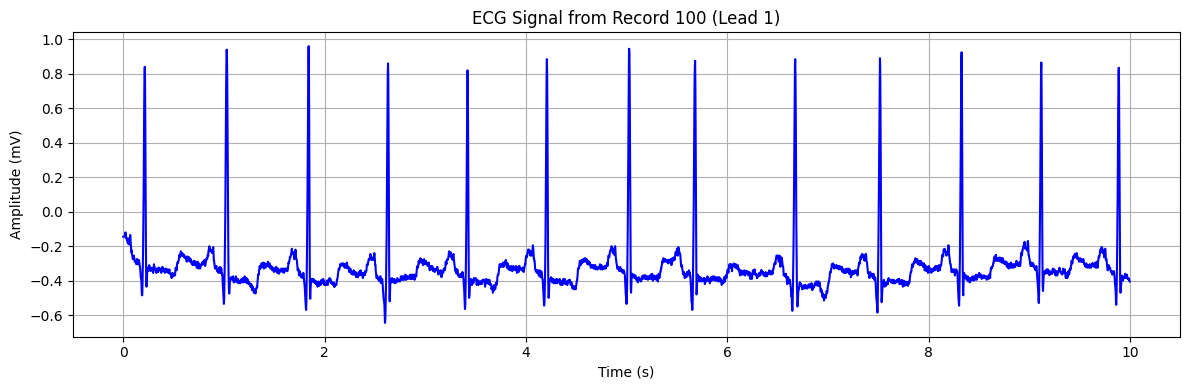

In [ ]:
# Plot first 10 seconds of signal
time = np.arange(ecg_signal.shape[0]) / sampling_rate

plt.figure(figsize=(12, 4))
plt.plot(time[:3600], ecg_signal[:3600], color='blue')
plt.title("ECG Signal from Record 100 (Lead 1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Load annotations
annotation = wfdb.rdann('mitbih_data/100', 'atr')
print(f"Annotation symbols (first 10): {annotation.symbol[:10]}")
print(f"Annotation times (samples): {annotation.sample[:10]}")


Annotation symbols (first 10): ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']
Annotation times (samples): [  18   77  370  662  946 1231 1515 1809 2044 2402]


In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360):
    nyq = 0.5 * fs
    b, a = butter(2, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

filtered_signal = bandpass_filter(ecg_signal)


In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.5 MB/s eta 0:00:00


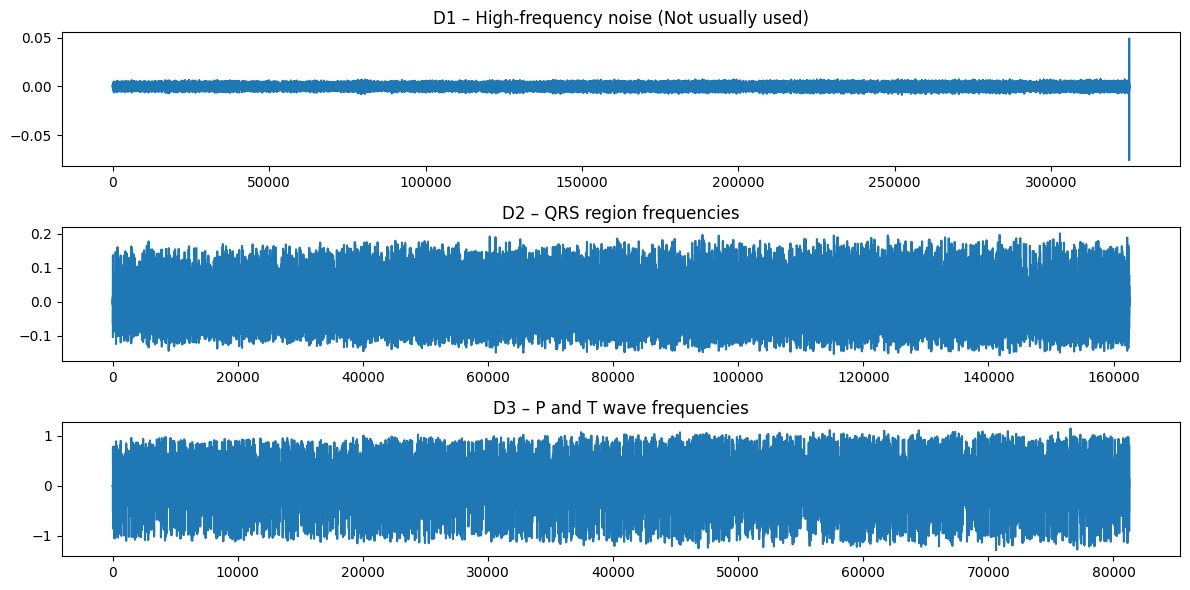

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Assume `filtered_signal` is your preprocessed ECG signal
wavelet = 'db6'
level = 4  # You can try 5 or 6 as well

coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)

# coeffs = [A4, D4, D3, D2, D1]
A4, D4, D3, D2, D1 = coeffs

# You can visualize the decomposed details
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(D1)
plt.title("D1 – High-frequency noise (Not usually used)")
plt.subplot(3, 1, 2)
plt.plot(D2)
plt.title("D2 – QRS region frequencies")
plt.subplot(3, 1, 3)
plt.plot(D3)
plt.title("D3 – P and T wave frequencies")
plt.tight_layout()
plt.show()


In [ ]:
# Combine D2, D3, D4 (features for QRS, P, and T)
features = np.concatenate([D2, D3, D4])


In [ ]:
coeffs_filtered = [A4, D4, D3, D2, D1]  # Remove A4, D4, D1
reconstructed = pywt.waverec(coeffs_filtered, wavelet)


In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 12.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/neurokit2/ecg/ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


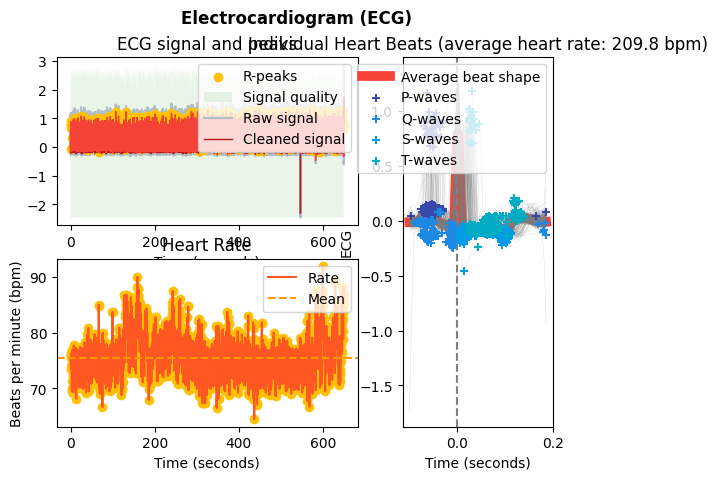

In [ ]:
import neurokit2 as nk

signals, info = nk.ecg_process(filtered_signal, sampling_rate=360)
nk.ecg_plot(signals)


In [ ]:
import pywt

wavelet = 'db6'  # Daubechies 6 is well-suited for ECG
level = 4

# Decompose signal
coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
A4, D4, D3, D2, D1 = coeffs


In [ ]:
# Zero all coefficients except the one we're interested in
def reconstruct_band(target_level, coeffs, wavelet):
    new_coeffs = [np.zeros_like(coeffs[i]) if i != target_level else coeffs[i] for i in range(len(coeffs))]
    return pywt.waverec(new_coeffs, wavelet)


qrs_band = reconstruct_band(3, coeffs, wavelet)  # D2 ~ QRS complex
t_wave_band = reconstruct_band(2, coeffs, wavelet)  # D3 ~ T wave
p_wave_band = reconstruct_band(1, coeffs, wavelet)  # D4 ~ P wave


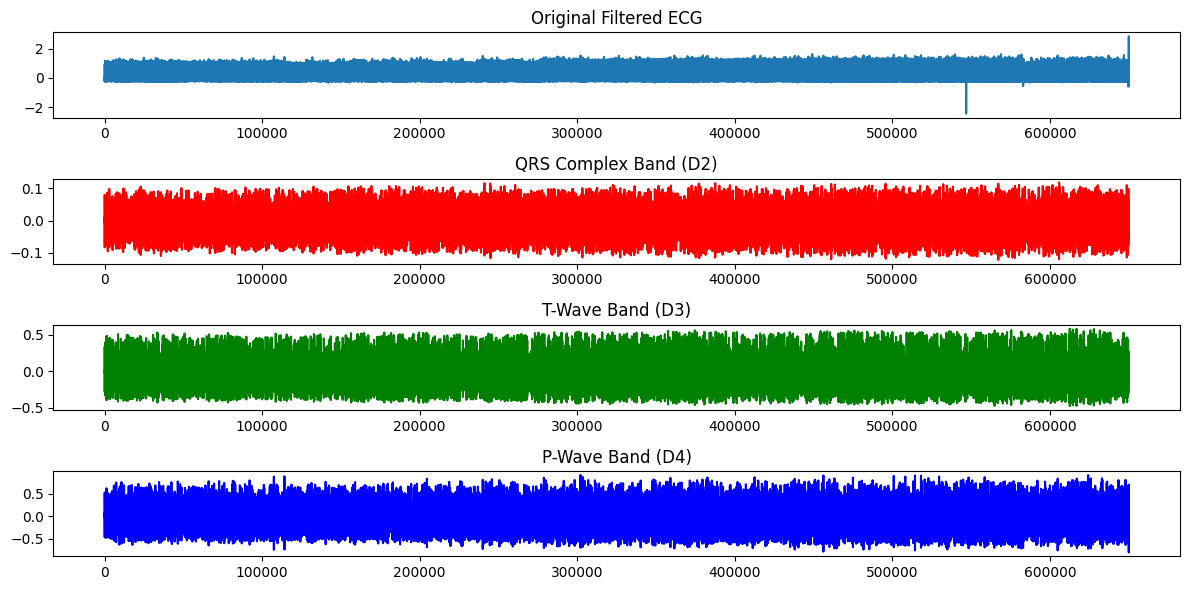

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(filtered_signal)
plt.title("Original Filtered ECG")

plt.subplot(4, 1, 2)
plt.plot(qrs_band, color='r')
plt.title("QRS Complex Band (D2)")

plt.subplot(4, 1, 3)
plt.plot(t_wave_band, color='g')
plt.title("T-Wave Band (D3)")

plt.subplot(4, 1, 4)
plt.plot(p_wave_band, color='b')
plt.title("P-Wave Band (D4)")

plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import find_peaks

peaks_qrs, _ = find_peaks(qrs_band, distance=100, height=np.max(qrs_band)*0.5)
peaks_t, _ = find_peaks(t_wave_band, distance=100, height=np.max(t_wave_band)*0.5)
peaks_p, _ = find_peaks(p_wave_band, distance=100, height=np.max(p_wave_band)*0.5)


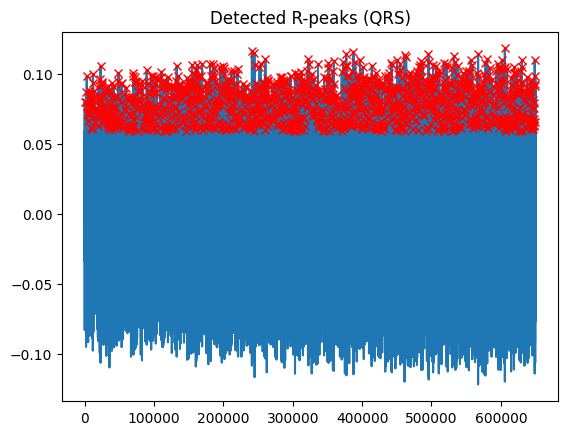

In [ ]:
from scipy.signal import find_peaks

# Assume `qrs_band` is reconstructed from wavelet D2 (QRS region)
peaks_r, _ = find_peaks(qrs_band, distance=150, height=np.max(qrs_band)*0.5)

# Visualize peaks (optional)
import matplotlib.pyplot as plt
plt.plot(qrs_band)
plt.plot(peaks_r, qrs_band[peaks_r], 'rx')
plt.title("Detected R-peaks (QRS)")
plt.show()


In [ ]:
# Assume ECG signal sampled at 360 Hz
fs = 360
rr_intervals = np.diff(peaks_r) / fs  # in seconds


In [ ]:
import numpy as np

# SDNN - Standard deviation of RR intervals
sdnn = np.std(rr_intervals)

# RMSSD - Root mean square of successive RR differences
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

# pNN50 - % of successive RR intervals differing by more than 50ms
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
pnn50 = (nn50 / len(rr_intervals)) * 100

print(f"SDNN: {sdnn:.4f} sec")
print(f"RMSSD: {rmssd:.4f} sec")
print(f"pNN50: {pnn50:.2f} %")


SDNN: 0.7964 sec
RMSSD: 1.1208 sec
pNN50: 67.14 %


In [ ]:
from scipy.stats import skew, kurtosis

mean_rr = np.mean(rr_intervals)
min_rr = np.min(rr_intervals)
max_rr = np.max(rr_intervals)
std_rr = np.std(rr_intervals)
skew_rr = skew(rr_intervals)
kurt_rr = kurtosis(rr_intervals)

print(f"Mean RR: {mean_rr:.4f}, Min: {min_rr:.4f}, Max: {max_rr:.4f}, Std: {std_rr:.4f}")
print(f"Skewness: {skew_rr:.4f}, Kurtosis: {kurt_rr:.4f}")


Mean RR: 1.2726, Min: 0.5222, Max: 8.1333, Std: 0.7964
Skewness: 2.4160, Kurtosis: 8.6162


In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

wavelet = 'db6'  # Daubechies 6, good for ECG
level = 5

coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)


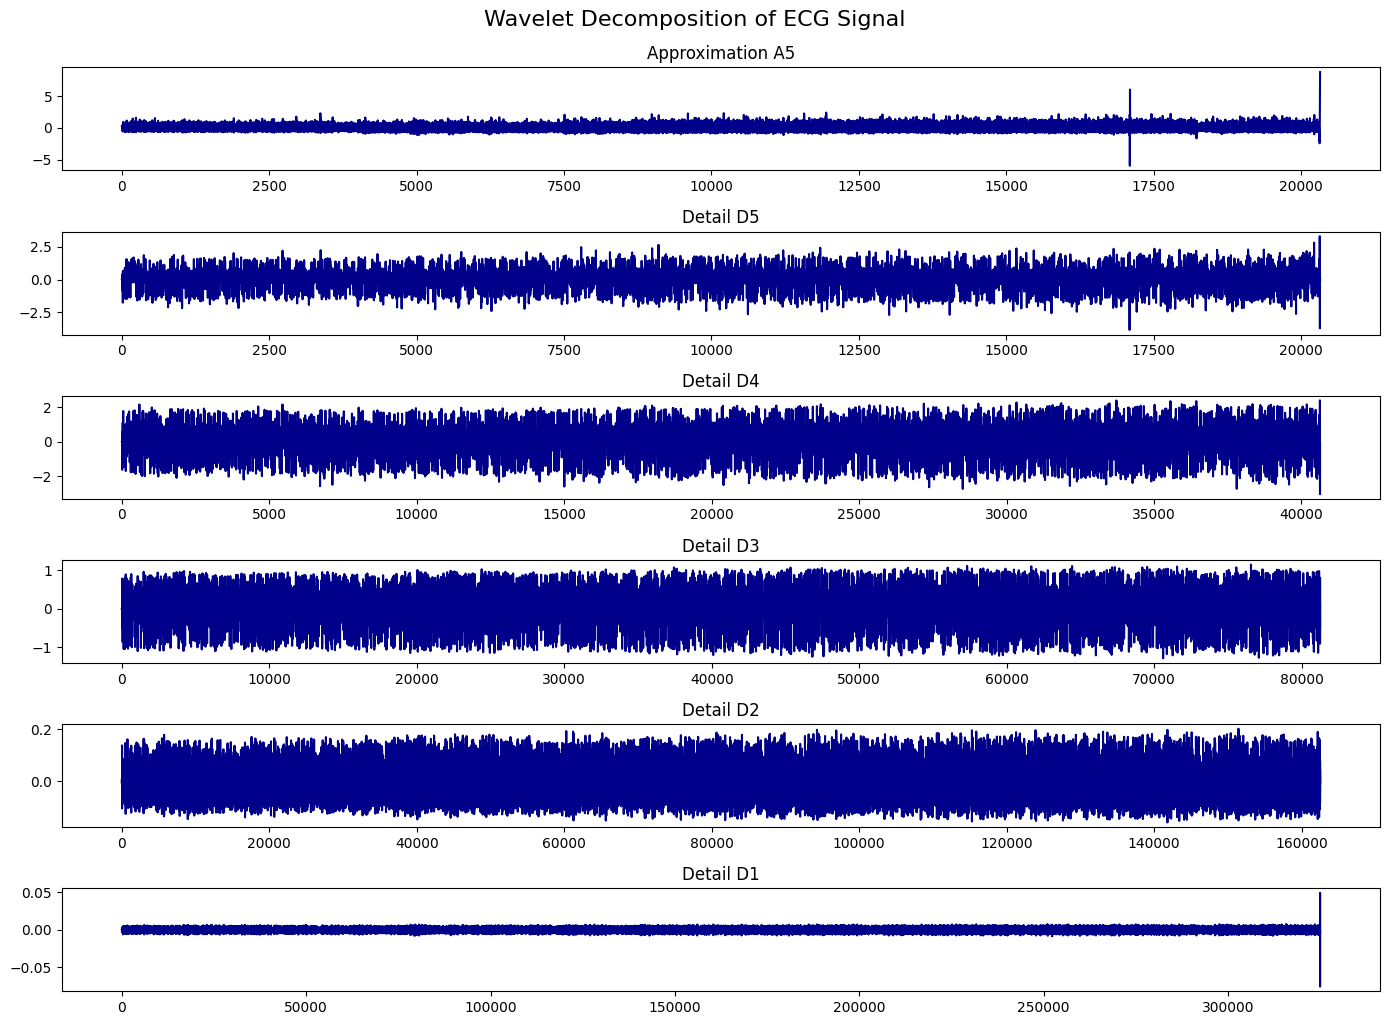

In [ ]:
plt.figure(figsize=(14, 10))
titles = ['Approximation A5', 'Detail D5', 'Detail D4', 'Detail D3', 'Detail D2', 'Detail D1']

for i, c in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i+1)
    plt.plot(c, color='darkblue')
    plt.title(titles[i])
    plt.tight_layout()

plt.suptitle("Wavelet Decomposition of ECG Signal", fontsize=16, y=1.02)
plt.show()


In [ ]:
import pywt
import numpy as np

def reconstruct_detail_band(coeffs, wavelet, target_detail_level):
    # Step 1: Create zero coefficients array
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    zero_arr = np.zeros_like(coeff_arr)

    # Step 2: Find which detail corresponds to target
    details = coeffs[1:]  # skip approximation
    if target_detail_level < 1 or target_detail_level > len(details):
        raise ValueError("Invalid detail level")

    # Map D1 to -1, D2 to -2, ...
    detail_index = -target_detail_level
    detail_coeff = details[detail_index]

    # Insert the selected detail band back
    # Get start and shape for that detail
    detail_key = list(coeffs[1].keys())[0] if isinstance(coeffs[1], dict) else ()
    detail_slice = coeff_slices[1:][detail_index]

    # Copy values into correct slice
    zero_arr[detail_slice] = coeff_arr[detail_slice]

    # Reconstruct using only that detail
    coeffs_from_array = pywt.array_to_coeffs(zero_arr, coeff_slices, output_format='wavedec')
    return pywt.waverec(coeffs_from_array, wavelet)


In [ ]:
import numpy as np
import pywt

def reconstruct_detail_band_1D(coeffs, wavelet, target_level):
    # Make a deep copy to preserve structure
    new_coeffs = [np.zeros_like(c) for c in coeffs]

    # coeffs[0] is approximation, coeffs[1:] are details
    new_coeffs[target_level] = coeffs[target_level]

    return pywt.waverec(new_coeffs, wavelet)


In [ ]:
coeffs = pywt.wavedec(ecg_signal, 'db4', level=5)


In [ ]:
# Decompose
wavelet = 'db4'
coeffs = pywt.wavedec(ecg_signal, wavelet, level=5)

# Reconstruct detail bands
p_wave_signal = reconstruct_detail_band_1D(coeffs, wavelet, 1)   # D5: P-wave
t_wave_signal = reconstruct_detail_band_1D(coeffs, wavelet, 2)   # D4: T-wave
qrs_signal    = reconstruct_detail_band_1D(coeffs, wavelet, 3)   # D3: QRS


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


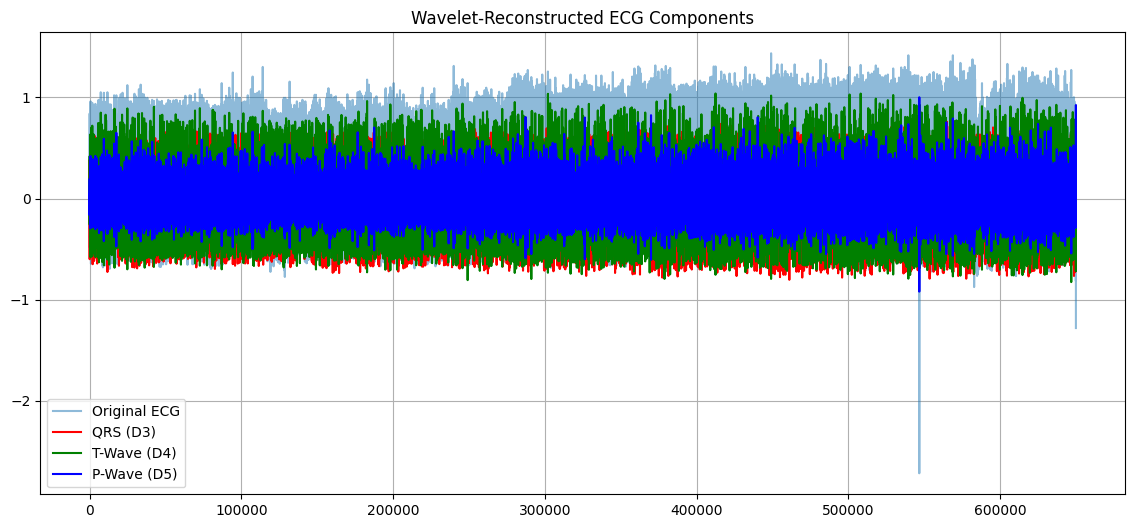

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(ecg_signal, label='Original ECG', alpha=0.5)
plt.plot(qrs_signal, label='QRS (D3)', color='red')
plt.plot(t_wave_signal, label='T-Wave (D4)', color='green')
plt.plot(p_wave_signal, label='P-Wave (D5)', color='blue')
plt.title("Wavelet-Reconstructed ECG Components")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def normalize_min_max(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


In [ ]:
def normalize_z_score(signal):
    return (signal - np.mean(signal)) / np.std(signal)


In [ ]:
# Normalize the original ECG signal and the components
ecg_normalized = normalize_z_score(ecg_signal)
qrs_normalized = normalize_z_score(qrs_signal)
t_wave_normalized = normalize_z_score(t_wave_signal)
p_wave_normalized = normalize_z_score(p_wave_signal)


In [ ]:
X = np.vstack([
    qrs_normalized,
    t_wave_normalized,
    p_wave_normalized
]).T  # Shape: (samples, features)


In [ ]:
window_size = 250  # number of samples per window
step_size = 250    # no overlap (can make it smaller for overlap)

segments = []
for i in range(0, len(qrs_normalized) - window_size, step_size):
    segment = [
        qrs_normalized[i:i+window_size],
        t_wave_normalized[i:i+window_size],
        p_wave_normalized[i:i+window_size]
    ]
    # Flatten the 3 × window_size to 1D vector
    segments.append(np.array(segment).flatten())

X = np.array(segments)
print("X shape:", X.shape)  # should be (n_samples, window_size × 3)


X shape: (2599, 750)


In [ ]:
# Let’s say half are normal (0), half abnormal (1)
y = np.array([0] * (X.shape[0] // 2) + [1] * (X.shape[0] // 2))


In [ ]:
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define number of classes from the training labels
num_classes = len(np.unique(y_train))

# Reshape input if not already shaped like (samples, timesteps, 1)
if len(X_train.shape) == 2:
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),

    Conv1D(filters=32, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 746, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 746, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 373, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 369, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 369, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 184, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 182, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 182, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 91, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,491,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,535,554 (5.86 MB)

 Trainable params: 1,535,106 (5.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_data=(X_test, y_test))


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.5118 - loss: 1.7076 - val_accuracy: 0.5173 - val_loss: 0.7300
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.5175 - loss: 0.8470 - val_accuracy: 0.5135 - val_loss: 0.9179
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.5322 - loss: 0.7460 - val_accuracy: 0.5135 - val_loss: 0.7762
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.5266 - loss: 0.6946 - val_accuracy: 0.5288 - val_loss: 0.7584
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.5255 - loss: 0.6854 - val_accuracy: 0.5385 - val_loss: 0.7097
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5445 - loss: 0.6870 - val_accuracy: 0.4885 - val_loss: 0.7437
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.5258 - loss: 0.6794 - val_accuracy: 0.5250 - val_loss: 0.7413
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.5529 - loss: 0.6834 - val_accuracy

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=30,                # You can tune epochs
    batch_size=32,            # You can tune this too
    validation_split=0.2,     # Split part of training data for validation
    verbose=1                 # Shows progress bar
)


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.6955 - loss: 0.5171 - val_accuracy: 0.5986 - val_loss: 0.6035
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.6167 - loss: 0.6255 - val_accuracy: 0.5288 - val_loss: 1.4202
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.6577 - loss: 0.5745 - val_accuracy: 0.6635 - val_loss: 0.6305
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.6756 - loss: 0.4930 - val_accuracy: 0.6635 - val_loss: 0.5522
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7075 - loss: 0.4970 - val_accuracy: 0.6995 - val_loss: 0.5161
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7348 - loss: 0.4465 - val_accuracy: 0.7332 - val_loss: 0.5002
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7521 - loss: 0.4332 - val_accuracy: 0.7019 - val_loss: 0.5048
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.7529 - loss: 0.4405 - val_accurac

In [ ]:
# Evaluate the trained model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.5885
Test Loss: 1.3508


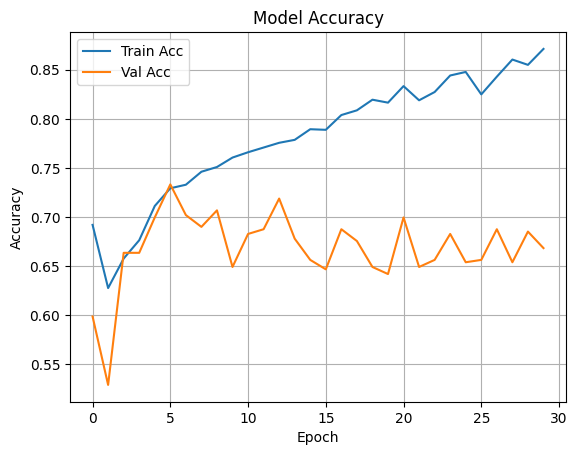

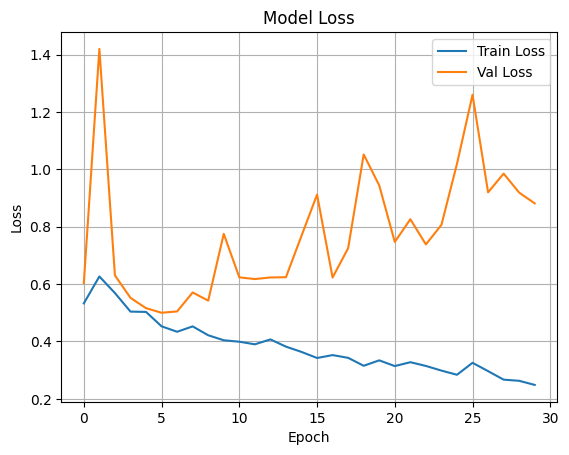

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


In [ ]:
!pip install scikeras


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

def create_model(learning_rate=0.001, num_conv_layers=3):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))

    # Base layer
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    if num_conv_layers >= 2:
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))

    if num_conv_layers >= 3:
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))

    if num_conv_layers >= 4:
        model.add(Conv1D(256, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
pip install --upgrade scikit-learn


In [ ]:
pip install scikeras


In [ ]:
pip install scikeras


In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


In [ ]:
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
model = KerasClassifier(model=create_model, verbose=0)


In [ ]:
param_grid = {
    'model__learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}


In [ ]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using build_fn instead of model
model = KerasClassifier(model=create_model, verbose=0, build_fn=create_model)

In [ ]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))

    # Conv1D Layers - dynamically added
    for i in range(hp.Int("num_conv_layers", min_value=2, max_value=4, step=1)):
        model.add(Conv1D(
            filters=hp.Int(f"filters_{i}", min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5]),
            activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
        activation='relu'))
    model.add(Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="ecg_tuning",
    project_name="ecg_cnn"
)


In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=32,
             validation_split=0.2,
             callbacks=[],
             verbose=1)


Trial 10 Complete [00h 01m 13s]
val_accuracy: 0.557692289352417

Best val_accuracy So Far: 0.5769230723381042
Total elapsed time: 00h 17m 28s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

# Get the best model and evaluate
best_model = tuner.get_best_models(1)[0]
best_model.evaluate(X_test, y_test)


Best Hyperparameters:
{'num_conv_layers': 4, 'filters_0': 64, 'kernel_size_0': 3, 'filters_1': 128, 'kernel_size_1': 3, 'dense_units': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.0001, 'filters_2': 96, 'kernel_size_2': 5, 'filters_3': 32, 'kernel_size_3': 5}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5053 - loss: 0.8313


[0.8156379461288452, 0.517307698726654]

In [ ]:
def create_model():
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Final model structure (based on your best performing one)
final_model = Sequential()
final_model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
final_model.add(MaxPooling1D(2))
final_model.add(Flatten())
final_model.add(Dense(64, activation='relu'))
final_model.add(Dense(5, activation='softmax'))  # Update if your classes ≠ 5

# Compile
final_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train
final_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4311 - loss: 1.0219 - val_accuracy: 0.5120 - val_loss: 0.7328
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5854 - loss: 0.6855 - val_accuracy: 0.5264 - val_loss: 0.7114
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5902 - loss: 0.6640 - val_accuracy: 0.5505 - val_loss: 0.7015
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6164 - loss: 0.6479 - val_accuracy: 0.5361 - val_loss: 0.7201
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6295 - loss: 0.6332 - val_accuracy: 0.5481 - val_loss: 0.7098
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6431 - loss: 0.6225 - val_accuracy: 0.5144 - val_loss: 0.7595
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6512 - loss: 0.6221 - val_accuracy: 0.5649 - val_loss: 0.7132
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6501 - loss: 0.6110 - val_accuracy: 0.5312 - val_loss: 0.

In [ ]:
final_model.save('ecg_model.h5')
